# Naive CAPM Calculations #

### CAPM Model using Simple Linear Regression Model ###

In [7]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from data_downloader import get_market_data
from other_data_functions import get_fred_data
from capm_toolkit import annual_to_daily_rate

In [8]:
# Stock Data
ticker = 'NVDA'

df_stock = get_market_data(
        ticker=ticker, 
        start_date='2015-01-01', 
        end_date='2025-01-01', 
        returns=True
    )

df_stock

[*********************100%***********************]  1 of 1 completed


Price,close,high,low,open,volume,returns
Date,,,,,,
2015-01-05,0.474906,0.484505,0.472747,0.483066,197952000,-0.017035
2015-01-06,0.460508,0.476106,0.460028,0.475626,197764000,-0.030787
2015-01-07,0.459308,0.467947,0.457868,0.463868,321808000,-0.002609
2015-01-08,0.476586,0.479466,0.464348,0.464588,283780000,0.036927
2015-01-09,0.478506,0.482106,0.471787,0.478266,209540000,0.004020
...,...,...,...,...,...,...
2024-12-24,140.197372,141.877094,138.627618,139.977407,105157000,0.003930
2024-12-26,139.907410,140.827275,137.707768,139.677451,116205600,-0.002070
2024-12-27,136.987869,138.997554,134.688253,138.527629,170582600,-0.021088


In [9]:
# We will use the 10-year bond rate as the RFR
rf = get_fred_data('DGS10')
rf.index = pd.to_datetime(rf.index)
rf = rf.loc['2015-01-01':]
rf.name = 'risk_free_rate'
rf.dropna(inplace=True)

# Daily Risk Free Rate
daily_rfr = annual_to_daily_rate(rf)

daily_rfr

2015-01-02    0.000083
2015-01-05    0.000080
2015-01-06    0.000077
2015-01-07    0.000077
2015-01-08    0.000080
                ...   
2025-06-10    0.000174
2025-06-11    0.000171
2025-06-12    0.000169
2025-06-13    0.000171
2025-06-16    0.000173
Name: risk_free_rate, Length: 2615, dtype: float64

In [10]:
# Benchmark Data
data_sp500 = pd.read_csv(r'..\additional_data\sp500.csv')
data_sp500.set_index('Date', inplace=True)
data_sp500.index = pd.to_datetime(data_sp500.index)

data_sp500

,sp_500
Date,
2015-01-05,-0.018447
2015-01-06,-0.008933
2015-01-07,0.011563
2015-01-08,0.017730
2015-01-09,-0.008439
...,...
2024-12-24,0.010982
2024-12-26,-0.000406
2024-12-27,-0.011117


In [17]:
# Create the DataFrame
data = pd.DataFrame()

data['stock'] = df_stock['returns']
data['daily_rfr'] = daily_rfr
data['benchmark'] = data_sp500['sp_500']

data = data.dropna()

data

,stock,daily_rfr,benchmark
Date,,,
2015-01-05,-0.017035,0.000080,-0.018447
2015-01-06,-0.030787,0.000077,-0.008933
2015-01-07,-0.002609,0.000077,0.011563
2015-01-08,0.036927,0.000080,0.017730
2015-01-09,0.004020,0.000078,-0.008439
...,...,...,...
2024-12-24,0.003930,0.000178,0.010982
2024-12-26,-0.002070,0.000178,-0.000406
2024-12-27,-0.021088,0.000179,-0.011117


In [18]:
# We use the excess returns
data['stock_excess'] = data['stock'] - data['daily_rfr']
data['market_excess'] = data['benchmark'] - data['daily_rfr']
data.dropna(inplace = True)

data

,stock,daily_rfr,benchmark,stock_excess,market_excess
Date,,,,,
2015-01-05,-0.017035,0.000080,-0.018447,-0.017115,-0.018527
2015-01-06,-0.030787,0.000077,-0.008933,-0.030865,-0.009011
2015-01-07,-0.002609,0.000077,0.011563,-0.002686,0.011486
2015-01-08,0.036927,0.000080,0.017730,0.036847,0.017650
2015-01-09,0.004020,0.000078,-0.008439,0.003942,-0.008517
...,...,...,...,...,...
2024-12-24,0.003930,0.000178,0.010982,0.003752,0.010804
2024-12-26,-0.002070,0.000178,-0.000406,-0.002248,-0.000583
2024-12-27,-0.021088,0.000179,-0.011117,-0.021268,-0.011297


In [19]:
# We know how to calculate a beta, but not a rolling beta
data['rolling_cov'] = data['stock_excess'].rolling(window=252).cov(data['market_excess'])
data['rolling_var_market'] = data['market_excess'].rolling(window=252).var()

# Rolling beta
data['rolling_beta'] = data['rolling_cov'] / data['rolling_var_market']

data.dropna()

,stock,daily_rfr,benchmark,stock_excess,market_excess,rolling_cov,rolling_var_market,rolling_beta
Date,,,,,,,,
2016-01-06,-0.042229,0.000086,-0.013202,-0.042315,-0.013288,0.000115,0.000097,1.184497
2016-01-07,-0.040452,0.000085,-0.023986,-0.040537,-0.024071,0.000118,0.000098,1.200201
2016-01-08,-0.021700,0.000084,-0.010898,-0.021784,-0.010981,0.000117,0.000098,1.196969
2016-01-11,0.001686,0.000085,0.000853,0.001601,0.000768,0.000118,0.000098,1.205763
2016-01-12,0.016706,0.000083,0.007773,0.016623,0.007689,0.000116,0.000097,1.197497
...,...,...,...,...,...,...,...,...
2024-12-24,0.003930,0.000178,0.010982,0.003752,0.010804,0.000167,0.000063,2.659689
2024-12-26,-0.002070,0.000178,-0.000406,-0.002248,-0.000583,0.000166,0.000062,2.666374
2024-12-27,-0.021088,0.000179,-0.011117,-0.021268,-0.011297,0.000168,0.000063,2.661608


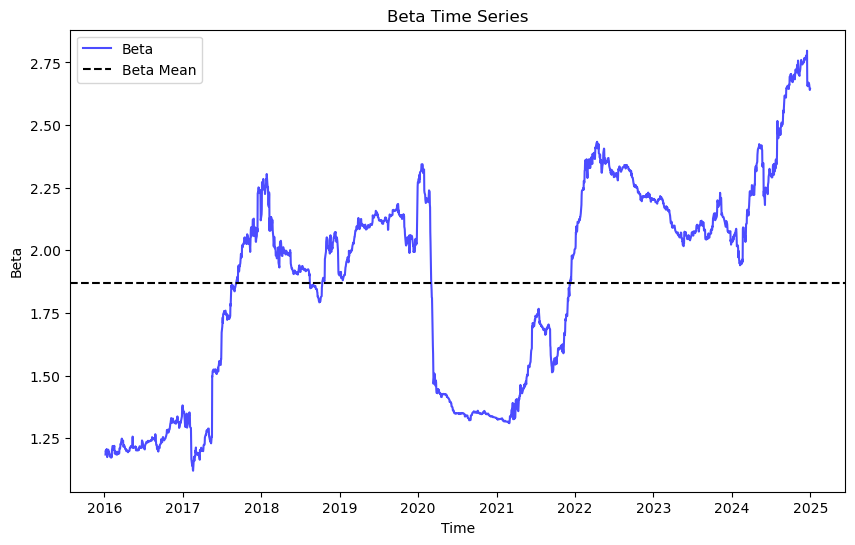

In [20]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(data['rolling_beta'], label='Beta', color='blue', alpha=0.7)
plt.axhline(y=data['rolling_beta'].mean(), color='black', linestyle='dashed', label='Beta Mean')

# Config
plt.title('Beta Time Series')
plt.xlabel('Time')
plt.ylabel('Beta')
plt.legend()

# Show
plt.show()

In [21]:
# Now we are interested in getting the alpha
data['rolling_avg_stock'] = data['stock_excess'].rolling(window=252).mean()
data['rolling_avg_market'] = data['market_excess'].rolling(window=252).mean()

data['rolling_alpha'] = data['rolling_avg_stock'] - data['rolling_beta'] * data['rolling_avg_market']

data.dropna()

,stock,daily_rfr,benchmark,stock_excess,market_excess,rolling_cov,rolling_var_market,rolling_beta,rolling_avg_stock,rolling_avg_market,rolling_alpha
Date,,,,,,,,,,,
2016-01-06,-0.042229,0.000086,-0.013202,-0.042315,-0.013288,0.000115,0.000097,1.184497,0.001758,-0.000209,0.002006
2016-01-07,-0.040452,0.000085,-0.023986,-0.040537,-0.024071,0.000118,0.000098,1.200201,0.001665,-0.000231,0.001943
2016-01-08,-0.021700,0.000084,-0.010898,-0.021784,-0.010981,0.000117,0.000098,1.196969,0.001701,-0.000239,0.001988
2016-01-11,0.001686,0.000085,0.000853,0.001601,0.000768,0.000118,0.000098,1.205763,0.001718,-0.000282,0.002058
2016-01-12,0.016706,0.000083,0.007773,0.016623,0.007689,0.000116,0.000097,1.197497,0.001638,-0.000321,0.002023
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.003930,0.000178,0.010982,0.003752,0.010804,0.000167,0.000063,2.659689,0.004052,0.000799,0.001926
2024-12-26,-0.002070,0.000178,-0.000406,-0.002248,-0.000583,0.000166,0.000062,2.666374,0.003972,0.000757,0.001953
2024-12-27,-0.021088,0.000179,-0.011117,-0.021268,-0.011297,0.000168,0.000063,2.661608,0.003901,0.000706,0.002021


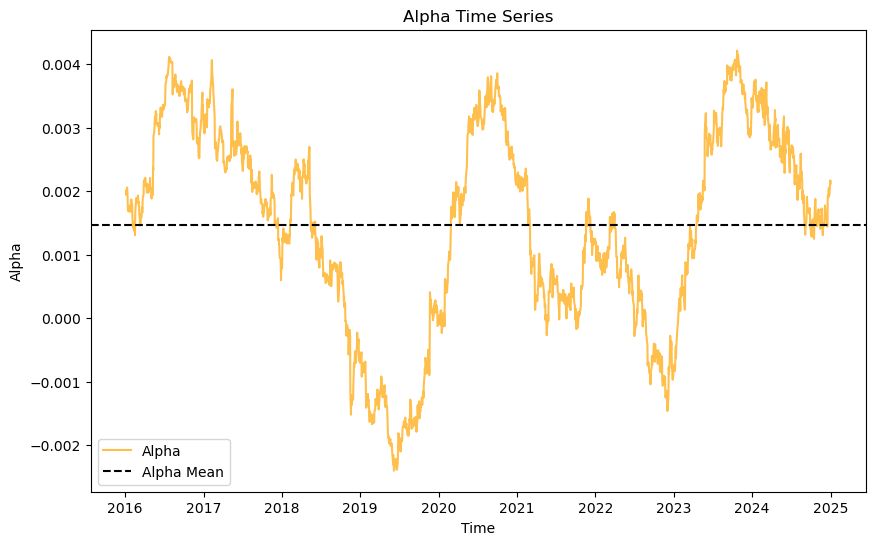

In [22]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(data['rolling_alpha'], label='Alpha', color='orange', alpha=0.7)
plt.axhline(y=data['rolling_alpha'].mean(), color='black', linestyle='dashed', label='Alpha Mean')

# Config
plt.title('Alpha Time Series')
plt.xlabel('Time')
plt.ylabel('Alpha')
plt.legend()

# Show
plt.show()

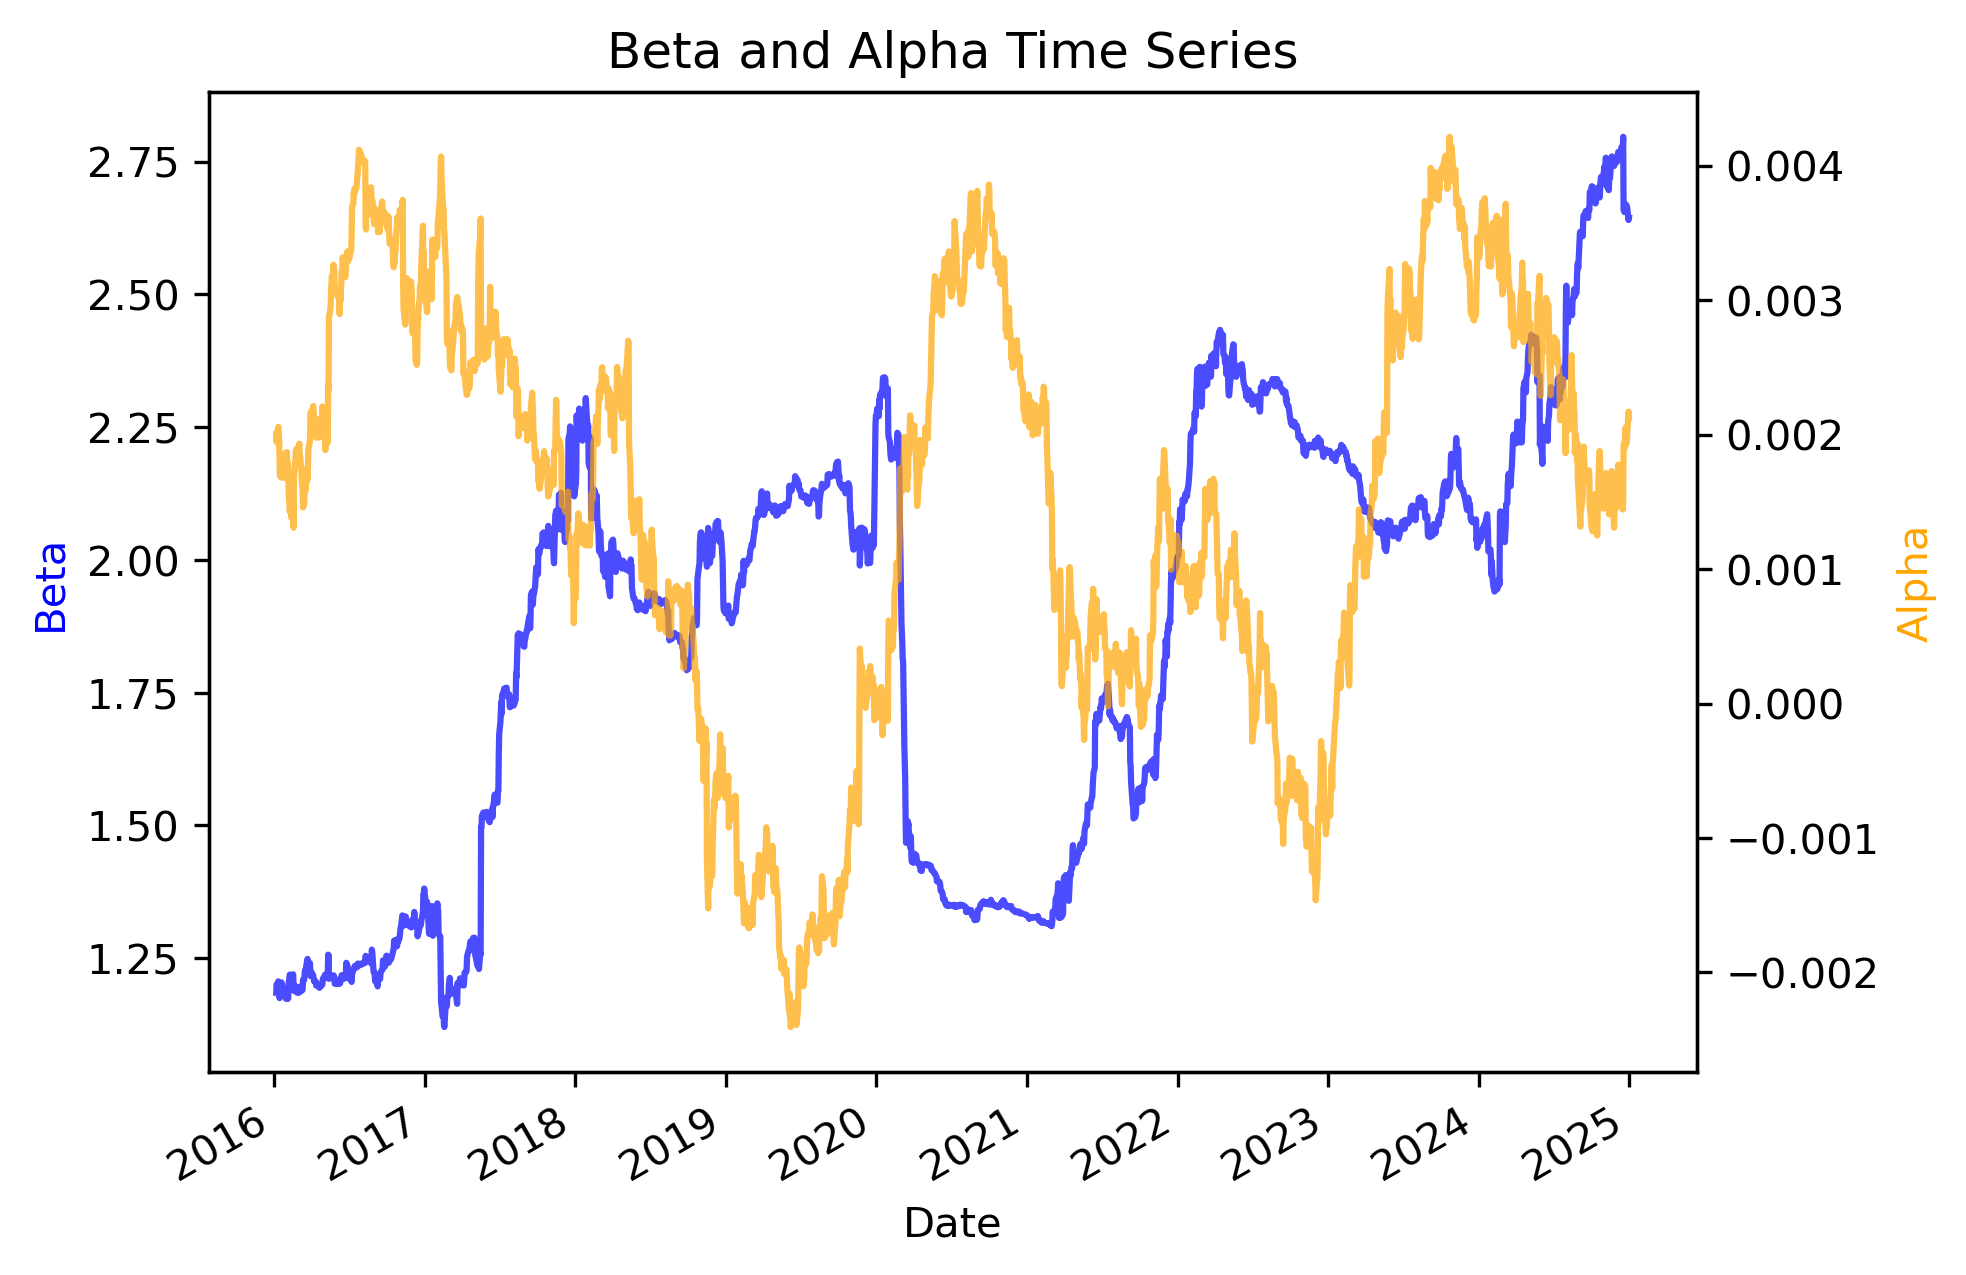

In [23]:
# Create Figure
fig, ax1 = plt.subplots(dpi = 300)

# Rolling Beta
data['rolling_beta'].plot(color = 'blue', ax = ax1, alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel(
    'Beta', 
    color='blue'
    )

# Rolling Alpha
ax2 = ax1.twinx()

data['rolling_alpha'].plot(color = 'orange', ax = ax2, alpha=0.7)
ax2.set_ylabel(
    'Alpha', 
    color='orange'
    )

plt.title('Beta and Alpha Time Series')
plt.show()

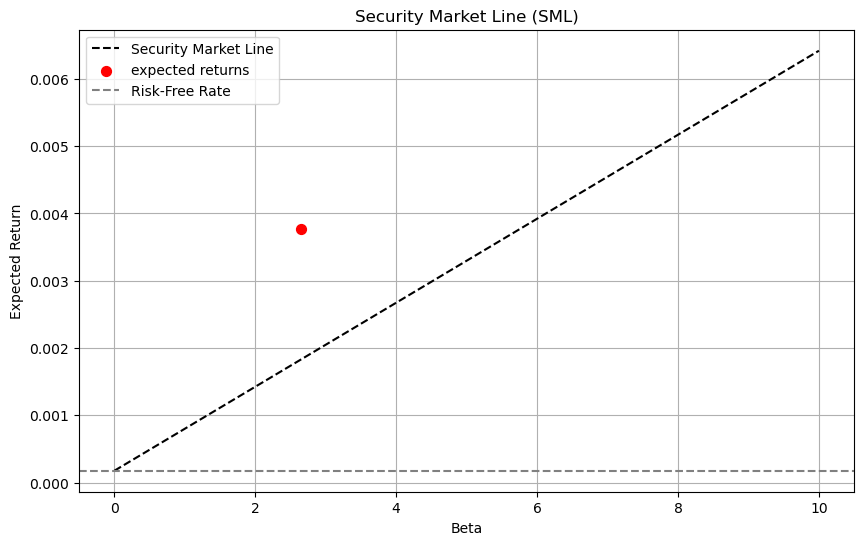

In [26]:
# Security Market Line
# Parameters
risk_free_rate = data['daily_rfr'].iloc[-1]
market_risk_premium = data['rolling_avg_market'].iloc[-1]

# Random Betas
betas = np.linspace(0, 10, 100)  # RANGE

# Expected Returns
expected_returns = risk_free_rate + market_risk_premium * betas

# Plot
plt.figure(figsize=(10, 6))
plt.plot(betas, expected_returns, color='black', linestyle='--', label='Security Market Line')
plt.scatter(data['rolling_beta'].iloc[-1], data['rolling_avg_stock'].iloc[-1], color='red', s=50, label='expected returns')  

# Config
plt.title('Security Market Line (SML)')
plt.xlabel('Beta')
plt.ylabel('Expected Return')

# RFR Line
plt.axhline(y=risk_free_rate, color='grey', linestyle='--', label='Risk-Free Rate')

# Legends
plt.legend()

plt.grid(True)
plt.show()

In [27]:
# Now we have to calculate the Treynor's Ratio
data['treynors_ratio'] = data['stock_excess'].mul(100).div(data['rolling_beta'])

data.dropna()

,stock,daily_rfr,benchmark,stock_excess,market_excess,rolling_cov,rolling_var_market,rolling_beta,rolling_avg_stock,rolling_avg_market,rolling_alpha,treynors_ratio
Date,,,,,,,,,,,,
2016-01-06,-0.042229,0.000086,-0.013202,-0.042315,-0.013288,0.000115,0.000097,1.184497,0.001758,-0.000209,0.002006,-3.572374
2016-01-07,-0.040452,0.000085,-0.023986,-0.040537,-0.024071,0.000118,0.000098,1.200201,0.001665,-0.000231,0.001943,-3.377525
2016-01-08,-0.021700,0.000084,-0.010898,-0.021784,-0.010981,0.000117,0.000098,1.196969,0.001701,-0.000239,0.001988,-1.819902
2016-01-11,0.001686,0.000085,0.000853,0.001601,0.000768,0.000118,0.000098,1.205763,0.001718,-0.000282,0.002058,0.132752
2016-01-12,0.016706,0.000083,0.007773,0.016623,0.007689,0.000116,0.000097,1.197497,0.001638,-0.000321,0.002023,1.388123
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.003930,0.000178,0.010982,0.003752,0.010804,0.000167,0.000063,2.659689,0.004052,0.000799,0.001926,0.141074
2024-12-26,-0.002070,0.000178,-0.000406,-0.002248,-0.000583,0.000166,0.000062,2.666374,0.003972,0.000757,0.001953,-0.084313
2024-12-27,-0.021088,0.000179,-0.011117,-0.021268,-0.011297,0.000168,0.000063,2.661608,0.003901,0.000706,0.002021,-0.799055


In [28]:
# And the Sharpe Ratio
data['rolling_std_stock'] = data['stock'].rolling(window=252).std()
data['sharpe_ratio'] = data['stock_excess'].div(data['rolling_std_stock'])

data.dropna()

,stock,daily_rfr,benchmark,stock_excess,market_excess,rolling_cov,rolling_var_market,rolling_beta,rolling_avg_stock,rolling_avg_market,rolling_alpha,treynors_ratio,rolling_std_stock,sharpe_ratio
Date,,,,,,,,,,,,,,
2016-01-06,-0.042229,0.000086,-0.013202,-0.042315,-0.013288,0.000115,0.000097,1.184497,0.001758,-0.000209,0.002006,-3.572374,0.021564,-1.962242
2016-01-07,-0.040452,0.000085,-0.023986,-0.040537,-0.024071,0.000118,0.000098,1.200201,0.001665,-0.000231,0.001943,-3.377525,0.021696,-1.868399
2016-01-08,-0.021700,0.000084,-0.010898,-0.021784,-0.010981,0.000117,0.000098,1.196969,0.001701,-0.000239,0.001988,-1.819902,0.021649,-1.006203
2016-01-11,0.001686,0.000085,0.000853,0.001601,0.000768,0.000118,0.000098,1.205763,0.001718,-0.000282,0.002058,0.132752,0.021648,0.073942
2016-01-12,0.016706,0.000083,0.007773,0.016623,0.007689,0.000116,0.000097,1.197497,0.001638,-0.000321,0.002023,1.388123,0.021554,0.771208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.003930,0.000178,0.010982,0.003752,0.010804,0.000167,0.000063,2.659689,0.004052,0.000799,0.001926,0.141074,0.032679,0.114816
2024-12-26,-0.002070,0.000178,-0.000406,-0.002248,-0.000583,0.000166,0.000062,2.666374,0.003972,0.000757,0.001953,-0.084313,0.032670,-0.068813
2024-12-27,-0.021088,0.000179,-0.011117,-0.021268,-0.011297,0.000168,0.000063,2.661608,0.003901,0.000706,0.002021,-0.799055,0.032705,-0.650284


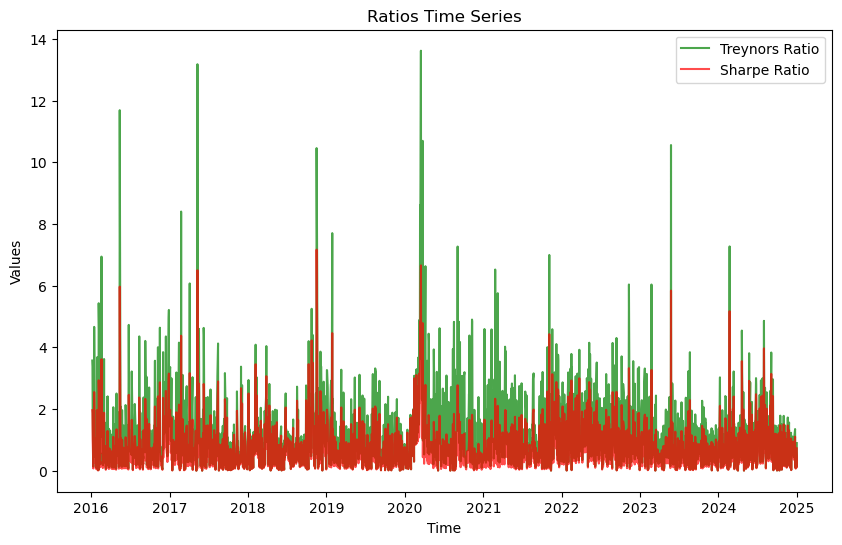

In [29]:
# Create Plot to demonstrate the Sharpe Ratio is always smaller than the Treynors Ratio

plt.figure(figsize=(10, 6))
plt.plot(abs(data['treynors_ratio']), label='Treynors Ratio', color='green', alpha=0.7)
plt.plot(abs(data['sharpe_ratio']), label='Sharpe Ratio', color='red', alpha=0.7)

# Config
plt.title('Ratios Time Series')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()

# Show
plt.show()

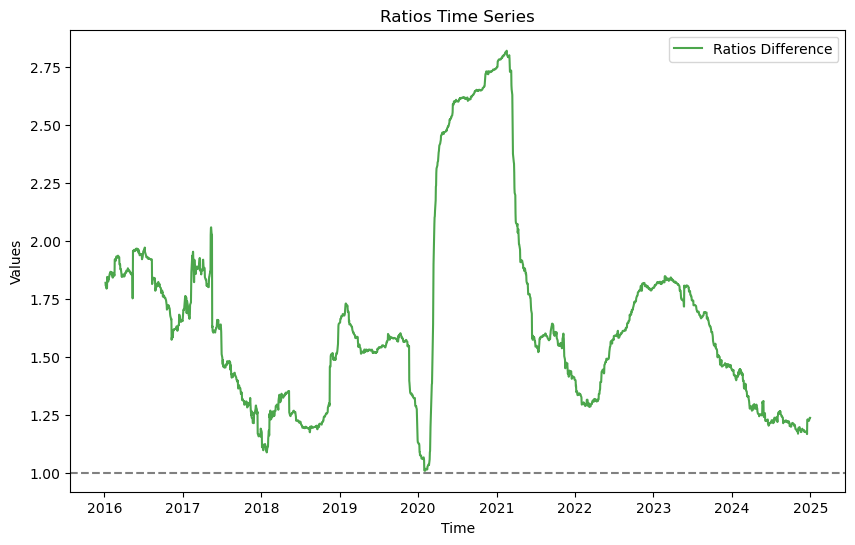

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(abs(data['treynors_ratio'] / abs(data['sharpe_ratio'])), label='Ratios Difference', color='green', alpha=0.7)
plt.axhline(y=1, color='grey', linestyle='--')

# Config
plt.title('Ratios Time Series')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()

# Show
plt.show()

In [31]:
daily_rfr.index.name = 'Date'
daily_rfr.to_csv(r'..\additional_data\rfr.csv', index=True)